**Enhancing Customer Retention through Machine Learning**: <br> Segmentation, Churn Prediction, and Product Recommendation – A Case Study on Flipkart Data.
<br><br>
Phase: **Data Preprocessing** <br>
By: Gia-My Nguyen <br>
Last updated (dd/mm/yyyy): 25/09/2025
<br><br>

**Completed:**
- Dropped redundant ('unnamed') columns & NULLs in *total_weighted_landing_price*.
- Identified "0" values in *procured_quantity*, *unit_selling_price*.
- Remove records with procured_quantity = 0, keep only those > 0."
- Checked consistency between category and category_id, handled the 'Syrups' case.
- Supporting files for easier cross-referencing (Location: data/supporting).
<br><br>

**Tasks Remaining**
- Handle "0" values in *unit_selling_price*
- Standardize str columns (before modelling)
- Create 'Revenue' 



In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [61]:
"""
    Convert all specified ID columns to string type.
    
    Parameters:
        df (pd.DataFrame): Input dataframe
        id_columns (list, optional): List of ID columns to convert. 
                                     If None, will auto-detect columns ending with '_id'.
    
    Returns:
        pd.DataFrame: Dataframe with converted ID columns
"""
    
def convert_id_to_str(df, id_columns=None):
    if id_columns is None:
        id_columns = [col for col in df.columns if col.endswith("_id") or col == 'dim_customer_key']
    
    for col in id_columns:
        if col in df.columns:
            df[col] = df[col].astype(str)
    
    return df


In [62]:
"""
    Create a mapping between 'category_id' and category_name'.  
    If a category name has multiple IDs -> append the ID to the name.
"""

def build_mapping(df, id_col, name_col):
    
    # Category name with multiple IDs
    dup_names = (
        df.groupby(name_col)[id_col]
        .nunique()
        .reset_index()
    )
    dup_names = dup_names[dup_names[id_col] > 1][name_col].tolist()

    # Handle duplicated names
    def rename(row):
        if row[name_col] in dup_names:
            return f"{row[name_col]} ({row[id_col]})"
        return row[name_col]

    df[name_col] = df.apply(rename, axis=1)

    # mapping data
    mapping = (
        df[[id_col, name_col]]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    return mapping


In [ ]:
# def clean_double_quotes(df, col_name):
#     """
#     Clean column:
#     - Remove surrounding double quotes
#     - Remove all extra quotes inside text
#     - Strip leading/trailing spaces
#     - Normalize multiple spaces into one
#     """
#     df[col_name] = (
#         df[col_name]
#         .astype(str)                                  
#         .str.strip('"')                               # bỏ " ở đầu và cuối
#         # .str.replace('"', '', regex=False)            # bỏ " còn sót bên trong
#         .str.strip()                                  # bỏ khoảng trắng đầu/cuối
#         .str.replace(r'\s+', ' ', regex=True)         # chuẩn hóa khoảng trắng
#     )
#     return df


# Sales

In [64]:
# read file

df_sales = pd.read_csv('Sales.csv')

In [65]:
# Basic information

df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46706387 entries, 0 to 46706386
Data columns (total 13 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Unnamed: 0.2                  int64  
 1   Unnamed: 0.1                  int64  
 2   Unnamed: 0                    int64  
 3   date_                         object 
 4   city_name                     object 
 5   order_id                      int64  
 6   cart_id                       int64  
 7   dim_customer_key              int64  
 8   procured_quantity             int64  
 9   unit_selling_price            float64
 10  total_discount_amount         float64
 11  product_id                    int64  
 12  total_weighted_landing_price  float64
dtypes: float64(3), int64(8), object(2)
memory usage: 4.5+ GB


In [66]:
# Drop "Unnamed" columns

cols_to_drop = [col for col in df_sales.columns if 'Unnamed' in col]
df_sales = df_sales.drop(columns=cols_to_drop)

In [67]:
# Check missing values

df_sales.isna().sum()

date_                               0
city_name                           0
order_id                            0
cart_id                             0
dim_customer_key                    0
procured_quantity                   0
unit_selling_price                  0
total_discount_amount               0
product_id                          0
total_weighted_landing_price    79355
dtype: int64

## Problem 01: <br> **79,355 missing values in "Total Weighted Landing Price"**

File: sales_missing_values.csv

**Proposal**

- Remove all these records from the master data

In [68]:
# sales_missing_values.csv

# sales_missing_values = df_sales[df_sales['total_weighted_landing_price'].isnull()]
# print(sales_missing_values.shape[0])

# sales_missing_values.to_csv('data/anomalies/sales_missing_values.csv')

In [69]:
# Drop all records where total_weighted_landing_price is NULL

df_sales_cleaned = df_sales.dropna(subset=['total_weighted_landing_price'])
print("Count after dropping NULL in total_weighted_landing_price:", len(df_sales_cleaned))

Count after dropping NULL in total_weighted_landing_price: 46627032


In [70]:
# Check NULL values again

df_sales_cleaned.isna().sum()

date_                           0
city_name                       0
order_id                        0
cart_id                         0
dim_customer_key                0
procured_quantity               0
unit_selling_price              0
total_discount_amount           0
product_id                      0
total_weighted_landing_price    0
dtype: int64

In [71]:
# Check abnormal data in 'procured_quantity' & 'unit_selling_price'

cols_to_check = ['procured_quantity', 'unit_selling_price']

for col in cols_to_check:
    zero_count = (df_sales_cleaned[col] == 0).sum()
    negative_count = (df_sales_cleaned[col] < 0).sum()
    
    print(f"Column: {col}")
    print(f"  Records = 0: {zero_count}")
    print(f"  Records < 0: {negative_count}\n")


Column: procured_quantity
  Records = 0: 178908
  Records < 0: 0

Column: unit_selling_price
  Records = 0: 48269
  Records < 0: 0



## Problem 02: <br> **178,908 records with procured_quantity = 0**
File: sales_zero_quantity.csv <br> <br>
No products were purchased -> Invalid transactions <br>
Possible reason: system error

**Proposal**: drop

In [72]:
# sales_zero_quantity.csv

# sales_zero_quantity = df_sales_cleaned[df_sales_cleaned['procured_quantity'] == 0]
# sales_zero_quantity.to_csv('data/anomalies/sales_zero_quantity.csv')

In [73]:
# Only get records with procured_quantity > 0

df_sales_cleaned = df_sales_cleaned[df_sales_cleaned['procured_quantity'] > 0]

# check agian
print("Records w. 'procured_quantity=0': ",df_sales_cleaned[df_sales_cleaned['procured_quantity'] == 0].shape[0])

Records w. 'procured_quantity=0':  0


## Problem 03: <br> **48,269 records with unit_selling_price = 0**
File: sales_zero_unit_price.csv<br> <br>
Products sold at zero price <br>
Possible reasons:
- Sample products / free gifts / special promotions
- Error in recording selling price

**Proposal**: add flag *is_free_product*

In [74]:
# sales_zero_unit_price.csv

# sales_zero_unit_price = df_sales_cleaned[df_sales_cleaned['unit_selling_price'] == 0]
# sales_zero_unit_price.to_csv('data/anomalies/sales_zero_unit_price.csv')

In [75]:
# Rename the date column and convert to datetime objects

df_sales_cleaned.rename(columns={'date_': 'date'}, inplace=True)
df_sales_cleaned['date'] = pd.to_datetime(df_sales_cleaned['date'])

In [76]:
# Convert ids to str

df_sales_cleaned = convert_id_to_str(df_sales_cleaned)

In [77]:
df_sales_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46448124 entries, 0 to 46706386
Data columns (total 10 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   date                          datetime64[ns]
 1   city_name                     object        
 2   order_id                      object        
 3   cart_id                       object        
 4   dim_customer_key              object        
 5   procured_quantity             int64         
 6   unit_selling_price            float64       
 7   total_discount_amount         float64       
 8   product_id                    object        
 9   total_weighted_landing_price  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 3.8+ GB


In [78]:
df_sales_cleaned.head(5)

,date,city_name,order_id,cart_id,dim_customer_key,procured_quantity,unit_selling_price,total_discount_amount,product_id,total_weighted_landing_price
0,2022-04-01,Mumbai,112246974,173273802,17995199,1,234.0,0.0,344107,202.513030
1,2022-04-01,Bengaluru,112246976,173273597,18259433,1,64.0,0.0,389676,48.714375
2,2022-04-01,Bengaluru,112247019,173123717,5402601,1,1031.0,0.0,39411,975.996000
3,2022-04-01,HR-NCR,112247045,172547459,15649744,1,57.0,0.0,369742,25.000000
4,2022-04-01,Mumbai,112247123,173081820,10127605,2,30.0,0.0,12872,57.980004


# Products

In [79]:
# Get products data

df_products = pd.read_csv('products.csv')

In [80]:
# Basic information

df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32226 entries, 0 to 32225
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         32226 non-null  int64 
 1   product_id         32226 non-null  int64 
 2   product_name       32226 non-null  object
 3   unit               32226 non-null  object
 4   product_type       32226 non-null  object
 5   brand_name         30788 non-null  object
 6   manufacturer_name  29810 non-null  object
 7   l0_category        32226 non-null  object
 8   l1_category        32226 non-null  object
 9   l2_category        32226 non-null  object
 10  l0_category_id     32226 non-null  int64 
 11  l1_category_id     32226 non-null  int64 
 12  l2_category_id     32226 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 3.2+ MB


In [81]:
# Drop "Unnamed" columns

cols_to_drop = [col for col in df_products.columns if 'Unnamed' in col]
df_products = df_products.drop(columns=cols_to_drop)


In [82]:
# Missing values

df_products.isnull().sum()

product_id              0
product_name            0
unit                    0
product_type            0
brand_name           1438
manufacturer_name    2416
l0_category             0
l1_category             0
l2_category             0
l0_category_id          0
l1_category_id          0
l2_category_id          0
dtype: int64

## Problem 04: <br> **Missing values in 'brand_name' & 'manufacturer_name'**
1. 'brand_name'         : 1,438 missing values
2. 'manufacturer_name'  : 2,416 missing values   

**Proposal:**
- Customer Segmentation and Churn Prediction -> No Problem!  
- Product Recommendation: assign 'Unknown'  

In [83]:
# Fill missing values with 'Unknown'

df_products['brand_name'] = df_products['brand_name'].fillna("Unknown")
df_products['manufacturer_name'] = df_products['manufacturer_name'].fillna("Unknown")

In [84]:
# Check the number of duplicate product_id values

duplicate_products = df_products[df_products.duplicated(subset=['product_id'], keep=False)]

print("Duplicated product_id:", duplicate_products['product_id'].nunique())
print("Total duplicated values:", len(duplicate_products))

Duplicated product_id: 0
Total duplicated values: 0


In [85]:
# Check product_name contains numeric-only values

mask = df_products["product_name"].astype(str).str.isnumeric()
numeric_names = df_products[mask]

print(f"Count: {numeric_names.shape[0]}")

Count: 0


In [86]:
# Convert ids to str

df_products = convert_id_to_str(df_products)

In [87]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32226 entries, 0 to 32225
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_id         32226 non-null  object
 1   product_name       32226 non-null  object
 2   unit               32226 non-null  object
 3   product_type       32226 non-null  object
 4   brand_name         32226 non-null  object
 5   manufacturer_name  32226 non-null  object
 6   l0_category        32226 non-null  object
 7   l1_category        32226 non-null  object
 8   l2_category        32226 non-null  object
 9   l0_category_id     32226 non-null  object
 10  l1_category_id     32226 non-null  object
 11  l2_category_id     32226 non-null  object
dtypes: object(12)
memory usage: 3.0+ MB


***Consistency check between category IDs and category names*** <br>
3 levels: l0, l1, l2

**What it does:**
1. Check if each category ID maps to only one category name.
2. Check if each category name maps to only one category ID.

In [88]:
# Consistency check between category IDs and category names

# Cross-check consistency between *_category_id and *_category
for level in ["l0", "l1", "l2"]:
    check = df_products.groupby(f"{level}_category_id")[f"{level}_category"].nunique()
    inconsistent_ids = check[check > 1]
    
    print(f"--- {level.upper()} ---")
    if inconsistent_ids.empty:
        print("[OK]: ID -> only 1 category_name")
    else:
        print("[Inconsistent]: ID → multiple category_names:")
        print(inconsistent_ids)

    check_name = df_products.groupby(f"{level}_category")[f"{level}_category_id"].nunique()
    inconsistent_names = check_name[check_name > 1]

    if inconsistent_names.empty:
        print("[OK]: category_name → only 1 ID\n")
    else:
        print("[Inconsistent]: category_name → multiple IDs:")
        print(inconsistent_names)


--- L0 ---
[OK]: ID -> only 1 category_name
[OK]: category_name → only 1 ID

--- L1 ---
[OK]: ID -> only 1 category_name
[OK]: category_name → only 1 ID

--- L2 ---
[OK]: ID -> only 1 category_name
[Inconsistent]: category_name → multiple IDs:
l2_category
Syrups    2
Name: l2_category_id, dtype: int64


**The above output shows:**
- L0 and L1 are fully consistent.
- L2 has a problem: "Syrups" is mapped to 2 different IDs.

In [89]:
# Filtered Syrups-only

syrups_detail = (
    df_products[df_products["l2_category"] == "Syrups"]
    .groupby(["l2_category", "l2_category_id"])["product_id"]
    .count()
    .reset_index()
    .rename(columns={"product_id": "count_products"})
)

print(syrups_detail)


  l2_category l2_category_id  count_products
0      Syrups           1136              43
1      Syrups           1289              31


## Problem 05: <br> **Duplicate category name with multiple IDs in L2**
Issue: The l2_category "Syrups" is linked to two different l2_category_id values <br>
-> category ID - name inconsistency. 

**Proposal:**
- l2_category_id = 1136 -> "Syrups (1136)"
- l2_category_id = 1289 -> "Syrups (1289)"


In [90]:
# export to csv

df_products_cleaned = df_products.copy()

l0_mapping = build_mapping(df_products_cleaned, "l0_category_id", "l0_category")
l1_mapping = build_mapping(df_products_cleaned, "l1_category_id", "l1_category")
l2_mapping = build_mapping(df_products_cleaned, "l2_category_id", "l2_category")

# l0_mapping.to_csv("data/supporting/l0_category.csv", index=False)
# l1_mapping.to_csv("data/supporting/l1_category.csv", index=False)
# l2_mapping.to_csv("data/supporting/l2_category.csv", index=False)

In [91]:
# test

# df_products_cleaned[df_products_cleaned['l2_category'] == 'Syrups (1136)'].head(3)
df_products_cleaned[df_products_cleaned['l2_category'] == 'Syrups (1289)'].head(3)


,product_id,product_name,unit,product_type,brand_name,manufacturer_name,l0_category,l1_category,l2_category,l0_category_id,l1_category_id,l2_category_id
30623,487147,Hershey's Genuine Chocolate Syrup - Pack of 2,2 x 1.3 kg,Syrup,Hershey's,HERSHEY INDIA PRIVATE LIMITED,Sweet Tooth,Syrups,Syrups (1289),9,1289,1289
30624,490896,Del Monte Chocolate Flavoured Syrup,600 g,Syrup,Del Monte,Del Monte Foods Pvt. Ltd,Sweet Tooth,Syrups,Syrups (1289),9,1289,1289
30640,479638,Hershey's Shell Chocolate Syrup,205 g,Syrup,Hershey's,HERSHEY INDIA PRIVATE LIMITED,Sweet Tooth,Syrups,Syrups (1289),9,1289,1289


In [92]:
# csv

# Unique product names
unique_products = df_products_cleaned[["product_id", "product_name"]].drop_duplicates()

unique_products.to_csv("data/supporting/unique_products.csv", index=False)


In [93]:
df_products_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32226 entries, 0 to 32225
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_id         32226 non-null  object
 1   product_name       32226 non-null  object
 2   unit               32226 non-null  object
 3   product_type       32226 non-null  object
 4   brand_name         32226 non-null  object
 5   manufacturer_name  32226 non-null  object
 6   l0_category        32226 non-null  object
 7   l1_category        32226 non-null  object
 8   l2_category        32226 non-null  object
 9   l0_category_id     32226 non-null  object
 10  l1_category_id     32226 non-null  object
 11  l2_category_id     32226 non-null  object
dtypes: object(12)
memory usage: 3.0+ MB


## Problem 06: <br> **1,478 *product_id* present in *Sales* but missing in *Products***



Number of *product_id* in *Sales* not found in *Products*: **1,478** <br>
-> The products metadata have not recorded <br>
**Proposal:** add dummy products to *Products*

Number of *product_id* in *Products* not found in *Sales*: **16,461** <br>
-> It can be unsold products. Totally fine!

In [94]:
# 

print("Count of product_id in *Sales*:", df_sales_cleaned["product_id"].unique().shape[0])
print("Count of product_id in *Products*:", df_products_cleaned["product_id"].unique().shape[0])
print("---")

sales_products = set(df_sales_cleaned["product_id"].unique())
products_master = set(df_products_cleaned["product_id"].unique())

missing_in_products = sales_products - products_master
print(f"[WARNING]\n Count of product_id in *Sales* not found in *Products*: {len(missing_in_products)}")
pd.Series(list(missing_in_products)).to_csv("data/supporting/missing_in_products.csv", index=False)


unused_in_sales = products_master - sales_products
print(f"[INFO]\n Count of product_id in *Products* not found in *Sales*: {len(unused_in_sales)}")


Count of product_id in *Sales*: 17243
Count of product_id in *Products*: 32226
---
[WARNING]
 Count of product_id in *Sales* not found in *Products*: 1478
[INFO]
 Count of product_id in *Products* not found in *Sales*: 16461


In [ ]:
#

# flitering
orders_with_missing_products = df_sales_cleaned[
    df_sales_cleaned["product_id"].isin(missing_in_products)
]

# to CSV
orders_with_missing_products.to_csv("data/anomalies/orders_missing_in_products.csv", index=False)

# print(f"[OK] Exported {orders_with_missing_products.shape[0]} orders to 'orders_missing_in_products.csv'")

In [ ]:
print(orders_with_missing_products['product_id'].unique().shape[0])

1478


In [ ]:
# Statistics on the number of orders for each product_id missing in Products.

missing_product_stats = (
    orders_with_missing_products.groupby("product_id")
    .size()
    .reset_index(name="order_count")
    .sort_values(by="order_count", ascending=False)
)

missing_product_stats.to_csv(
    "data/supporting/missing_product_stats.csv", index=False
)

In [ ]:
# Dummy products

df_dummy = pd.DataFrame({
    "product_id": list(missing_in_products),
    "product_name": [f"Unknown {pid}" for pid in missing_in_products],
    "unit": "Unknown",
    "product_type": "Unknown",
    "brand_name": "Unknown",
    "manufacturer_name": "Unknown",
    "l0_category": "Unknown",
    "l1_category": "Unknown",
    "l2_category": "Unknown",
    "l0_category_id": "Unknown",
    "l1_category_id": "Unknown",
    "l2_category_id": "Unknown"
})

In [ ]:
df_dummy.head(5)

,product_id,product_name,l0_category,l1_category,l2_category
0,475713,Unknown 475713,Unknown,Unknown,Unknown
1,448554,Unknown 448554,Unknown,Unknown,Unknown
2,194125,Unknown 194125,Unknown,Unknown,Unknown
3,484732,Unknown 484732,Unknown,Unknown,Unknown
4,483879,Unknown 483879,Unknown,Unknown,Unknown


In [ ]:
# Add dummy products to Products

df_products_cleaned_extended = pd.concat([df_products_cleaned, df_dummy])

In [ ]:
df_products_cleaned_extended.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33704 entries, 0 to 1477
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_id         33704 non-null  object
 1   product_name       33704 non-null  object
 2   unit               32226 non-null  object
 3   product_type       32226 non-null  object
 4   brand_name         32226 non-null  object
 5   manufacturer_name  32226 non-null  object
 6   l0_category        33704 non-null  object
 7   l1_category        33704 non-null  object
 8   l2_category        33704 non-null  object
 9   l0_category_id     32226 non-null  object
 10  l1_category_id     32226 non-null  object
 11  l2_category_id     32226 non-null  object
dtypes: object(12)
memory usage: 3.3+ MB


In [ ]:
df_products_cleaned_extended.head(5)

,product_id,product_name,unit,product_type,brand_name,manufacturer_name,l0_category,l1_category,l2_category,l0_category_id,l1_category_id,l2_category_id
0,476763,Christmas - Card,1 unit,Card,Unknown,HOT,Specials,Bill Breaker,Bill Breaker,343,1741,1741
1,483436,Plum BodyLovin' Hawaiian Rumba Shower Gel - Sa...,20 ml,Sample,Plum BodyLovin',Pureplay Skin Sciences India Pvt. Ltd.,Specials,Free Store,Free Store,343,1493,1493
2,476825,Diwali Gift Card Free - Sample,1 unit,Sample,Unknown,HOT,Specials,Bill Breaker,Bill Breaker,343,1741,1741
3,483438,Plum BodyLovin' Trippin' Mimosas Shower Gel - ...,20 ml,Sample,Plum BodyLovin',Pureplay Skin Sciences India Pvt. Ltd.,Specials,Free Store,Free Store,343,1493,1493
4,480473,Flipkart Valentine Day Greeting - Card,1 unit,Card,Flipkart,Dummy Manufacturer,Specials,Bill Breaker,Bill Breaker,343,1741,1741


In [3]:
# Draft 

df_sales_cleaned = pd.read_csv('data/cleaned/sales_cleaned.csv')

In [4]:
# Draft

df_products_cleaned = pd.read_csv('data/cleaned/products_cleaned.csv')

## Problem 07: <br> **Discount exceeds item price**
Transactions where discount amount > (unit_price × quantity) <br>
This is mathematically impossible in legitimate transactions.

**Proposal**: Remove these transactions

In [5]:
# Calculate pre-discount total
df_sales_cleaned['pre_discount_total'] = df_sales_cleaned['unit_selling_price'] * df_sales_cleaned['procured_quantity']

# Check for impossible discounts
df_sales_cleaned['discount_exceeds_price'] = df_sales_cleaned['total_discount_amount'] > df_sales_cleaned['pre_discount_total']

impossible_discounts = df_sales_cleaned['discount_exceeds_price'].sum()
print(f"Transactions where discount > unit_price × quantity: {impossible_discounts:,}")
print(f"Percentage: {impossible_discounts/len(df_sales_cleaned)*100:.4f}%")

if impossible_discounts > 0:
    print("\nSample of impossible transactions:")
    bad_trans = df_sales_cleaned[df_sales_cleaned['discount_exceeds_price']]
    print(bad_trans[['dim_customer_key', 'unit_selling_price', 'procured_quantity', 
                     'total_discount_amount', 'pre_discount_total']].head(10))

Transactions where discount > unit_price × quantity: 231
Percentage: 0.0005%

Sample of impossible transactions:
         dim_customer_key  unit_selling_price  procured_quantity  \
136213           16908735                19.0                  3   
291288           17024439                39.0                  1   
475796           18330883                50.0                  1   
548958             815083                50.0                  1   
1400541          12776690                52.0                  1   
1511812            644324                95.0                  1   
1635507            919138                20.0                  4   
1826106             16892               242.0                  1   
1846232            334237                56.0                  1   
2000750          12858442               153.0                  1   

         total_discount_amount  pre_discount_total  
136213                    58.0                57.0  
291288                    40.0  

In [ ]:
# Export problematic transactions for review

# df_sales_cleaned[df_sales_cleaned['discount_exceeds_price']].to_csv(
#     'data/anomalies/sales_impossible_discounts.csv', index=False
# )

In [6]:
# Remove impossible discount transactions
print(f"Records before removal: {len(df_sales_cleaned):,}")
df_sales_cleaned = df_sales_cleaned[~df_sales_cleaned['discount_exceeds_price']]
print(f"Records after removal: {len(df_sales_cleaned):,}")
print(f"Removed: {impossible_discounts:,} transactions")

# Drop helper column
df_sales_cleaned = df_sales_cleaned.drop(columns=['pre_discount_total', 'discount_exceeds_price'])

Records before removal: 46,448,124
Records after removal: 46,447,893
Removed: 231 transactions


## Problem 08: <br> **Negative values in price or discount**
Check for negative values in critical financial fields.

**Proposal**: Review and remove if data errors

In [7]:
# Check for negative values
print("Checking for negative values:")
print(f"  Negative unit_selling_price: {(df_sales_cleaned['unit_selling_price'] < 0).sum():,}")
print(f"  Negative total_discount_amount: {(df_sales_cleaned['total_discount_amount'] < 0).sum():,}")
print(f"  Negative total_weighted_landing_price: {(df_sales_cleaned['total_weighted_landing_price'] < 0).sum():,}")

# If any negatives found, investigate
if (df_sales_cleaned['unit_selling_price'] < 0).sum() > 0:
    print("\nNegative prices found:")
    print(df_sales_cleaned[df_sales_cleaned['unit_selling_price'] < 0].head())

Checking for negative values:
  Negative unit_selling_price: 0
  Negative total_discount_amount: 0
  Negative total_weighted_landing_price: 0


## Problem 09: <br> **Duplicate transactions**
Check for exact duplicate records that might indicate data entry errors.

**Proposal**: Keep first occurrence, remove duplicates

In [8]:
# Check for duplicates
print(f"Total records: {len(df_sales_cleaned):,}")

# Check complete duplicates
complete_dups = df_sales_cleaned.duplicated().sum()
print(f"Complete duplicate rows: {complete_dups:,}")

# Check logical duplicates (same order, product, customer)
logical_dups = df_sales_cleaned.duplicated(
    subset=['order_id', 'product_id', 'dim_customer_key'], 
    keep=False
).sum()
print(f"Logical duplicates (same order+product+customer): {logical_dups:,}")

if logical_dups > 0:
    print("\nSample of duplicate transactions:")
    dup_sample = df_sales_cleaned[df_sales_cleaned.duplicated(
        subset=['order_id', 'product_id', 'dim_customer_key'], 
        keep=False
    )].sort_values(['order_id', 'product_id']).head(10)
    print(dup_sample[['order_id', 'dim_customer_key', 'product_id', 
                      'procured_quantity', 'unit_selling_price']])

Total records: 46,447,893
Complete duplicate rows: 0
Logical duplicates (same order+product+customer): 0


In [9]:
# Remove complete duplicates only (keep first)
if complete_dups > 0:
    df_sales_cleaned = df_sales_cleaned.drop_duplicates()
    print(f"Removed {complete_dups:,} complete duplicate rows")
    print(f"Records remaining: {len(df_sales_cleaned):,}")

## Problem 10: <br> **Date validation**
Check for dates outside the expected range.

**Proposal**: Flag or investigate unexpected dates

In [10]:
# Convert to datetime first
df_sales_cleaned['date'] = pd.to_datetime(df_sales_cleaned['date'])

In [11]:
# Check date range
print(f"Date range: {df_sales_cleaned['date'].min()} to {df_sales_cleaned['date'].max()}")

Date range: 2022-04-01 00:00:00 to 2022-07-10 00:00:00


In [12]:
# Check for future dates (if running in 2022)
expected_max = pd.to_datetime('2022-07-31')
future_dates = (df_sales_cleaned['date'] > expected_max).sum()
if future_dates > 0:
    print(f"Transactions with dates after {expected_max.date()}: {future_dates:,}")

In [13]:
# Check for very old dates
expected_min = pd.to_datetime('2022-01-01')
old_dates = (df_sales_cleaned['date'] < expected_min).sum()
if old_dates > 0:
    print(f"Transactions with dates before {expected_min.date()}: {old_dates:,}")

## Problem 11: <br> **Extremely high quantities**
Quantities > 100 could be legitimate bulk orders or data entry errors.

**Proposal**: Flag for review, keep if legitimate business pattern

In [14]:
# Check for extreme quantities
high_qty = df_sales_cleaned[df_sales_cleaned['procured_quantity'] > 100]
print(f"Transactions with quantity > 100: {len(high_qty):,}")
print(f"Percentage: {len(high_qty)/len(df_sales_cleaned)*100:.4f}%")

if len(high_qty) > 0:
    print(f"\nMax quantity: {df_sales_cleaned['procured_quantity'].max():,}")
    print("\nQuantity distribution for high-qty orders:")
    print(high_qty['procured_quantity'].describe())
    
    print("\nSample of high-quantity transactions:")
    print(high_qty[['dim_customer_key', 'product_id', 'procured_quantity', 
                    'unit_selling_price', 'total_discount_amount']].head(10))

Transactions with quantity > 100: 0
Percentage: 0.0000%


## Problem 12: <br> **Extreme unit prices**
Very high or very low unit prices may indicate errors.

**Proposal**: Review products with unit_price > $10,000 or < $1

In [15]:
# Check extreme prices
very_high_price = (df_sales_cleaned['unit_selling_price'] > 10000).sum()
very_low_price = (df_sales_cleaned['unit_selling_price'] < 0).sum() 


print(f"Transactions with unit_price > $10,000: {very_high_price:,}")
print(f"Transactions with unit_price less than free ($0): {very_low_price:,}")

if very_high_price > 0:
    print(f"\nMax unit price: ${df_sales_cleaned['unit_selling_price'].max():,.2f}")
    expensive = df_sales_cleaned[df_sales_cleaned['unit_selling_price'] > 10000]
    print("\nMost expensive products:")
    print(expensive[['product_id', 'unit_selling_price', 'procured_quantity']].head(10))

Transactions with unit_price > $10,000: 18
Transactions with unit_price less than free ($0): 0

Max unit price: $10,999.00

Most expensive products:
          product_id  unit_selling_price  procured_quantity
33128957      477200             10999.0                  1
34195848      477200             10999.0                  1
34358346      477200             10999.0                  1
34728672      477200             10999.0                  1
35329711      477200             10999.0                  1
35529000      477200             10999.0                  1
35561732      477080             10499.0                  1
36308576      477200             10999.0                  1
36721934      477200             10999.0                  1
37054097      477200             10999.0                  1


In [ ]:
# Export extremely high unit price products for review

# expensive.to_csv('data/supporting/highest_unit_price.csv', index=False)

'Unspecified' products (id: 477200) is the highest price product.

## Problem 13: <br> **Landing price > selling price (always-loss items)**
Items where cost consistently exceeds selling price.

**Proposal**: Normal for promotions, but flag if >90% of transactions are losses

In [16]:
# Calculate revenue and profit at transaction level
df_sales_cleaned['revenue'] = (df_sales_cleaned['unit_selling_price'] * 
                                df_sales_cleaned['procured_quantity']) - df_sales_cleaned['total_discount_amount']
df_sales_cleaned['profit'] = df_sales_cleaned['revenue'] - df_sales_cleaned['total_weighted_landing_price']

# Check always-loss transactions
always_loss = (df_sales_cleaned['profit'] < 0).sum()
print(f"Loss-making transactions: {always_loss:,} ({always_loss/len(df_sales_cleaned)*100:.2f}%)")

# Check products that are ALWAYS sold at a loss
product_loss = df_sales_cleaned.groupby('product_id').agg({
    'profit': ['sum', 'count', lambda x: (x < 0).sum()]
}).reset_index()
product_loss.columns = ['product_id', 'total_profit', 'transaction_count', 'loss_count']
product_loss['loss_pct'] = (product_loss['loss_count'] / product_loss['transaction_count'] * 100)

always_loss_products = product_loss[product_loss['loss_pct'] > 90]
print(f"\nProducts sold at loss >90% of the time: {len(always_loss_products):,}")
if len(always_loss_products) > 0:
    print(always_loss_products.head(10))

Loss-making transactions: 3,975,935 (8.56%)

Products sold at loss >90% of the time: 1,240
     product_id  total_profit  transaction_count  loss_count    loss_pct
165         392 -9.147212e+05               7247        7204   99.406651
166         393 -1.978894e+06              15929       15825   99.347103
211         634 -1.463692e+04               1277        1261   98.747063
217         658 -7.753281e+01                 62          58   93.548387
265         916 -4.203645e+04               1835        1806   98.419619
291        1035 -2.411183e+04                997         937   93.981946
292        1036 -3.284686e+03                135         135  100.000000
293        1037 -2.173700e+03                 91          87   95.604396
312        3110 -8.656589e+03                379         375   98.944591
330        3493 -4.218529e+05               5143        4827   93.855726


In [ ]:
# Export loss-making transactions to CSV

# df_sales_cleaned[df_sales_cleaned['profit'] < 0].to_csv('data/supporting/loss_making_transactions.csv', index=False)

## Problem 14: <br> **Inconsistent pricing for same product**
- Same product_id should have relatively stable pricing.
- 10 products with the CV > 1, all of these are Sample/Free gift products.

**Proposal**: 
- Review products with extreme price variance 
- Split the dataset into 2 subset: Non-Commercial (Sample/Free Products) and Commercial. We will working on the Commercial data

**Notes:** CV = Coefficient of Variation

In [17]:
# Check price consistency per product
price_stats = df_sales_cleaned.groupby('product_id')['unit_selling_price'].agg([
    'mean', 'std', 'min', 'max', 'count'
]).reset_index()
price_stats['cv'] = price_stats['std'] / price_stats['mean']  # Coefficient of variation

# Flag products with high price variance (CV > 1) and multiple transactions
inconsistent = price_stats[(price_stats['cv'] > 1) & (price_stats['count'] > 5)]
print(f"Products with inconsistent pricing (CV > 1): {len(inconsistent):,}")

if len(inconsistent) > 0:
    print("\nSample of products with varying prices:")
    print(inconsistent.sort_values('cv', ascending=False).head(10))
    
    # Show example transactions for one inconsistent product
    sample_product = inconsistent.iloc[0]['product_id']
    print(f"\nExample: product_id {sample_product}")
    print(df_sales_cleaned[df_sales_cleaned['product_id'] == sample_product][
        ['date', 'unit_selling_price', 'total_discount_amount']
    ].sort_values('date').head(10))

Products with inconsistent pricing (CV > 1): 10

Sample of products with varying prices:
       product_id      mean       std  min  max  count         cv
16513      486125  0.001070  0.032698  0.0  1.0   2804  30.561410
17090      488060  0.001812  0.042563  0.0  1.0    552  23.494680
16512      486124  0.002431  0.049248  0.0  1.0  21389  20.257001
17093      488063  0.003257  0.057073  0.0  1.0    307  17.521415
16978      487659  0.004283  0.065309  0.0  1.0   4203  15.249765
17089      488059  0.010929  0.147844  0.0  2.0    183  13.527749
17092      488062  0.005650  0.075165  0.0  1.0    177  13.304135
16979      487660  0.013859  0.116969  0.0  1.0    938   8.439774
15071      483694  0.016327  0.130287  0.0  2.0   2205   7.980079
14934      483436  0.038462  0.196116  0.0  1.0     26   5.099020

Example: product_id 483436.0
               date  unit_selling_price  total_discount_amount
9056448  2022-04-28                 0.0                    0.0
15168067 2022-04-28          

In [18]:
price_stats[(price_stats['cv'] > 1)]

,product_id,mean,std,min,max,count,cv
14934,483436,0.038462,0.196116,0.0,1.0,26,5.099020
15071,483694,0.016327,0.130287,0.0,2.0,2205,7.980079
16512,486124,0.002431,0.049248,0.0,1.0,21389,20.257001
16513,486125,0.001070,0.032698,0.0,1.0,2804,30.561410
16978,487659,0.004283,0.065309,0.0,1.0,4203,15.249765
16979,487660,0.013859,0.116969,0.0,1.0,938,8.439774
17089,488059,0.010929,0.147844,0.0,2.0,183,13.527749
17090,488060,0.001812,0.042563,0.0,1.0,552,23.494680
17092,488062,0.005650,0.075165,0.0,1.0,177,13.304135
17093,488063,0.003257,0.057073,0.0,1.0,307,17.521415


483436: Plum BodyLovin' Hawaiian Rumba Shower Gel - Sample <br>
483694: Dabur Vita Chocolate Health Drink - Sample <br>
486124: Kari kari Salt & Pepper Snack Sample <br>
486125: Maggi Liquid Coconut Milk Sample<br>
487659: The Laughing Cow Creamy Cheese Sample<br>
487660: Tender Coconut Free Gift<br>
488059: Sleepy Owl Cinnamon Brew Coffee Sample<br>
488060: Sleepy Owl Cinnamon Brew Coffee (Set of 3) Sample<br>
488062: Sleepy Owl Cold Brew Coffee (Mocha) Sample<br>
488063: Sleepy Owl Cold Brew Coffee (New Orleans) Sample<br>
<br>

The products with CV>1 are all Sample/Free products.

In [64]:
# product_id 483436: Plum BodyLovin' Hawaiian Rumba Shower Gel - Sample

df_sales_cleaned[df_sales_cleaned['product_id'] == 483436]

,date,city_name,order_id,cart_id,dim_customer_key,procured_quantity,unit_selling_price,total_discount_amount,product_id,total_weighted_landing_price,revenue,profit
9056448,2022-04-28,Delhi,118287199,189236221,18128584,1,0.0,0.0,483436,0.012,0.0,-0.012
9210422,2022-04-29,HR-NCR,118400582,183669422,10004701,1,0.0,0.0,483436,0.012,0.0,-0.012
9259424,2022-04-29,Delhi,118463176,189701327,18803546,1,0.0,0.0,483436,0.012,0.0,-0.012
9448431,2022-04-28,HR-NCR,118288668,189238867,15540546,1,0.0,0.0,483436,0.012,0.0,-0.012
9744298,2022-04-28,Delhi,118285981,189230029,3346956,1,0.0,0.0,483436,0.012,0.0,-0.012
9901155,2022-04-29,HR-NCR,118400306,166338108,653528,1,0.0,0.0,483436,0.012,0.0,-0.012
10149718,2022-04-29,HR-NCR,118399099,188225372,15434763,1,0.0,0.0,483436,0.012,0.0,-0.012
10356983,2022-04-29,Delhi,118460890,189697524,3351350,1,0.0,0.0,483436,0.012,0.0,-0.012
10715584,2022-04-29,Delhi,118456410,187336679,5024259,1,0.0,0.0,483436,0.012,0.0,-0.012
11016688,2022-04-28,Delhi,118295930,189257351,8528169,1,0.0,0.0,483436,0.012,0.0,-0.012


In [ ]:
# Export transactions where CV > 0.5

price_stats = (
    df_sales_cleaned
    .groupby('product_id')['unit_selling_price']
    .agg(['mean', 'std'])
    .reset_index()
)
price_stats['cv'] = price_stats['std'] / price_stats['mean']

threshold = 0.5
volatile_products = price_stats[price_stats['cv'] > threshold]['product_id']

volatile_transactions = df_sales_cleaned[df_sales_cleaned['product_id'].isin(volatile_products)]

# volatile_transactions.to_csv("data/anomalies/volatile_transactions.csv", index=False)

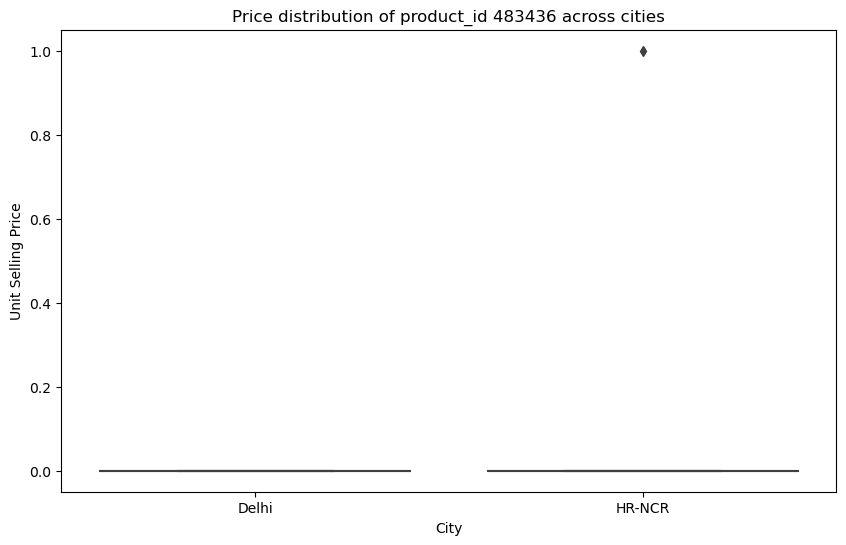

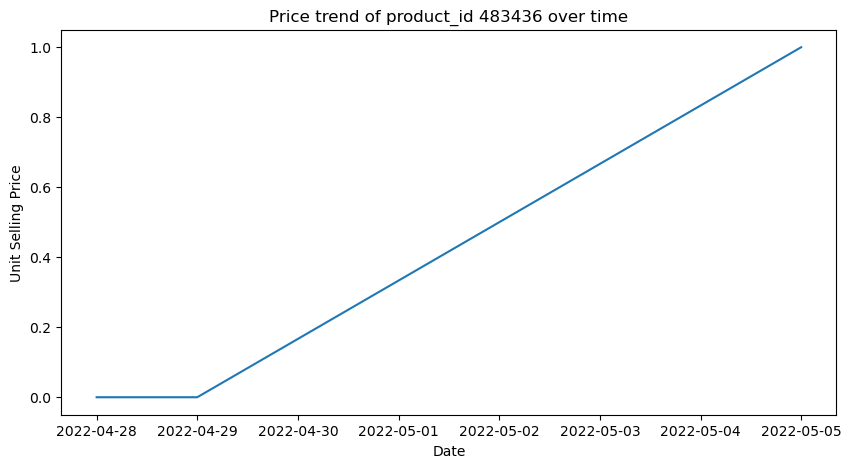

In [ ]:
sample_id = 483436 # Plum BodyLovin' Hawaiian Rumba Shower Gel - Sample
subset = df_sales_cleaned[df_sales_cleaned['product_id'] == sample_id]

plt.figure(figsize=(10,6))
sns.boxplot(data=subset, x='city_name', y='unit_selling_price')
plt.title(f"Price distribution of product_id {sample_id} across cities")
plt.ylabel("Unit Selling Price")
plt.xlabel("City")
plt.show()

# Check over time
plt.figure(figsize=(10,5))
sns.lineplot(data=subset.sort_values('date'), x='date', y='unit_selling_price')
plt.title(f"Price trend of product_id {sample_id} over time")
plt.ylabel("Unit Selling Price")
plt.xlabel("Date")
plt.show()


In [20]:
# products CV > 0.5 

print(f"Products CV > 0.5: {price_stats[(price_stats['cv'] > 0.5)].shape[0]}")
price_stats[(price_stats['cv'] > 0.5)].head(10)

Products CV > 0.5: 59


,product_id,mean,std,cv
372,3898,14.151155,7.812850,0.552100
415,5065,49.801653,34.905496,0.700890
438,5851,22.333333,11.260973,0.504223
440,5855,25.007205,14.513811,0.580385
623,11350,35.106796,31.941230,0.909830
2575,91891,24.349284,12.392714,0.508956
3487,203822,19.163390,10.226771,0.533662
3684,239518,127.888889,67.461923,0.527504
3950,294591,34.208302,26.253708,0.767466
3951,294592,23.183888,13.242654,0.571201


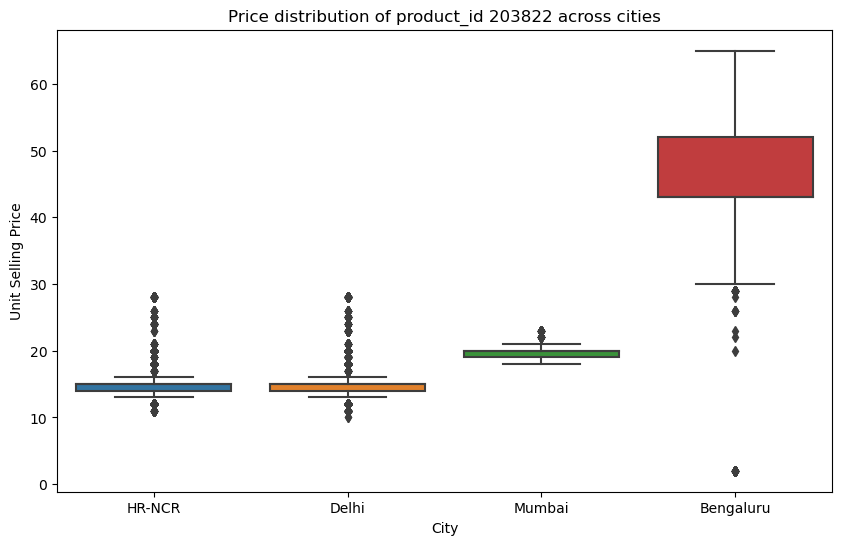

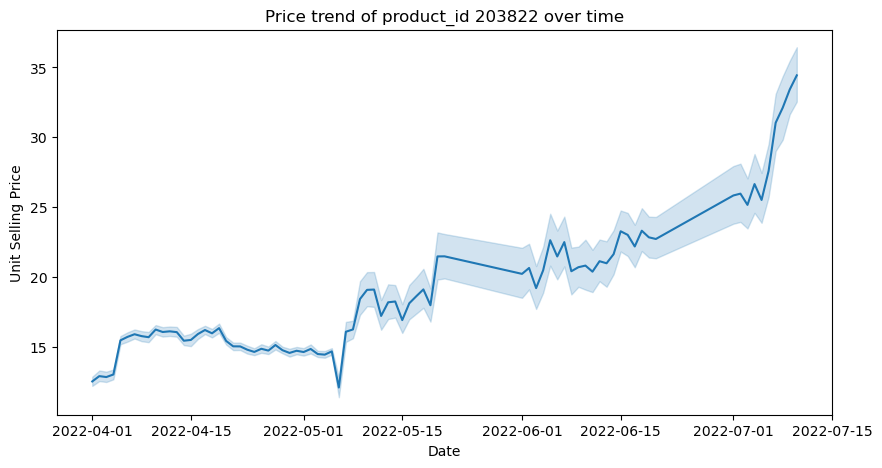

In [ ]:
sample_id = 203822 # Raw Turmeric
subset = df_sales_cleaned[df_sales_cleaned['product_id'] == sample_id]

plt.figure(figsize=(10,6))
sns.boxplot(data=subset, x='city_name', y='unit_selling_price')
plt.title(f"Price distribution of product_id {sample_id} across cities")
plt.ylabel("Unit Selling Price")
plt.xlabel("City")
plt.show()

# Check over time
plt.figure(figsize=(10,5))
sns.lineplot(data=subset.sort_values('date'), x='date', y='unit_selling_price')
plt.title(f"Price trend of product_id {sample_id} over time")
plt.ylabel("Unit Selling Price")
plt.xlabel("Date")
plt.show()


In [21]:
# merge product_name to sales

df_sales_merged = df_sales_cleaned.merge(
    df_products_cleaned[['product_id', 'product_name']],
    on='product_id',
    how='left'  
)

In [22]:
print(df_sales_merged[['product_id', 'product_name']].head())
print(f"Rows with missing product_name: {df_sales_merged['product_name'].isna().sum():,}")

   product_id                                    product_name
0      344107  Aashirvaad Superior MP Whole Wheat Atta (5 kg)
1      389676                          GMC Kashmiri Red Rajma
2       39411                   Sunpure Refined Sunflower Oil
3      369742                                        Broccoli
4       12872                 Amul Gold Full Cream Fresh Milk
Rows with missing product_name: 0


In [23]:

mask_non_commercial = df_sales_merged['product_name'].str.contains('sample|free gift', case=False, na=False)

# Non-commercial products
df_sales_non_commercial = df_sales_merged[mask_non_commercial]

In [30]:
print(f"Count: {df_sales_non_commercial.shape[0]:,}")
print(f"Non-commercial products: {df_sales_non_commercial['product_id'].nunique()}")

# df_sales_non_commercial.to_csv('data/supporting/sales_non_commercial_products.csv', index=False)

Count: 33,588
Non-commercial products: 16


In [34]:
df_sales_non_commercial['unit_selling_price'].describe()

count    33588.000000
mean         0.003811
std          0.062575
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: unit_selling_price, dtype: float64

In [37]:
print(df_sales_non_commercial[df_sales_non_commercial['unit_selling_price'] > 0].shape[0])

df_sales_non_commercial[df_sales_non_commercial['unit_selling_price'] > 0].head(5)

126


,date,city_name,order_id,cart_id,dim_customer_key,procured_quantity,unit_selling_price,total_discount_amount,product_id,total_weighted_landing_price,revenue,profit,product_name
15362237,2022-07-04,Mumbai,135915923,231433862,19421606,1,1.0,0.0,483694,12.550001,1.0,-11.550001,Dabur Vita Chocolate Health Drink - Sample
15563995,2022-07-03,Delhi,135822833,231272573,17814764,1,1.0,0.0,487659,0.012000,1.0,0.988000,The Laughing Cow Creamy Cheese Sample
15656718,2022-07-03,Mumbai,135658766,230978982,10375031,1,1.0,0.0,483694,12.550001,1.0,-11.550001,Dabur Vita Chocolate Health Drink - Sample
15671459,2022-07-03,Delhi,135747212,231138773,6126146,1,1.0,0.0,483694,0.000000,1.0,1.000000,Dabur Vita Chocolate Health Drink - Sample
15700743,2022-07-02,Delhi,135499456,229180101,19754360,1,1.0,0.0,483694,0.000000,1.0,1.000000,Dabur Vita Chocolate Health Drink - Sample


In [27]:
# Remove Sample/Free gift products

df_sales_commercial = df_sales_merged[~mask_non_commercial]


In [32]:
print(f"Count: {df_sales_commercial.shape[0]:,}")
print(f"Commercial Products: {df_sales_commercial['product_id'].nunique():,}")

df_sales_commercial.head(10)

Count: 46,414,305
Commercial Products: 17,227


,date,city_name,order_id,cart_id,dim_customer_key,procured_quantity,unit_selling_price,total_discount_amount,product_id,total_weighted_landing_price,revenue,profit,product_name
0,2022-04-01,Mumbai,112246974,173273802,17995199,1,234.0,0.0,344107,202.513030,234.0,31.486970,Aashirvaad Superior MP Whole Wheat Atta (5 kg)
1,2022-04-01,Bengaluru,112246976,173273597,18259433,1,64.0,0.0,389676,48.714375,64.0,15.285625,GMC Kashmiri Red Rajma
2,2022-04-01,Bengaluru,112247019,173123717,5402601,1,1031.0,0.0,39411,975.996000,1031.0,55.004000,Sunpure Refined Sunflower Oil
3,2022-04-01,HR-NCR,112247045,172547459,15649744,1,57.0,0.0,369742,25.000000,57.0,32.000000,Broccoli
4,2022-04-01,Mumbai,112247123,173081820,10127605,2,30.0,0.0,12872,57.980004,60.0,2.019996,Amul Gold Full Cream Fresh Milk
5,2022-04-01,HR-NCR,112247149,173274225,479129,1,65.0,0.0,99407,61.500000,65.0,3.500000,Amul Masti Curd
6,2022-04-01,Bengaluru,112247170,173273989,8658748,1,115.0,0.0,439935,103.059875,115.0,11.940125,Grocery Arhar Dal/Toor Dal
7,2022-04-01,Mumbai,112247182,173273662,16541671,1,20.0,0.0,424394,15.399999,20.0,4.600001,Crax Double Mazza Namkeen
8,2022-04-01,Delhi,112247233,173269263,21466,1,24.0,0.0,470636,18.000000,24.0,6.000000,Banana
9,2022-04-01,Delhi,112247239,173274446,13522664,1,36.0,0.0,311,32.388370,36.0,3.611630,Slice Thickest Mango Drink


## Problem 15: <br> **Discount percentage patterns**
Check if discounts follow typical retail patterns (5%, 10%, 15%, 20%, etc).

**Proposal**: Flag unusual discount percentages for review

In [118]:
# Calculate discount percentage
df_sales_cleaned['discount_pct'] = (
    df_sales_cleaned['total_discount_amount'] / 
    (df_sales_cleaned['unit_selling_price'] * df_sales_cleaned['procured_quantity']) * 100
).fillna(0)

# Check discount distribution
print("Discount percentage distribution:")
print(df_sales_cleaned[df_sales_cleaned['discount_pct'] > 0]['discount_pct'].describe())

# Check for odd discount percentages (not multiples of 5)
discounted = df_sales_cleaned[df_sales_cleaned['discount_pct'] > 0].copy()
discounted['is_standard'] = discounted['discount_pct'].apply(
    lambda x: abs(round(x / 5) * 5 - x) < 1  # Within 1% of a multiple of 5
)
non_standard = (~discounted['is_standard']).sum()
print(f"\nNon-standard discount percentages: {non_standard:,} ({non_standard/len(discounted)*100:.2f}%)")

if non_standard > 0:
    print("\nSample of unusual discounts:")
    print(discounted[~discounted['is_standard']][
        ['unit_selling_price', 'procured_quantity', 'total_discount_amount', 'discount_pct']
    ].head(10))

Discount percentage distribution:
count    1.073321e+06
mean     2.340311e+01
std      2.085118e+01
min      1.602564e-01
25%      1.033755e+01
50%      2.054795e+01
75%      2.471042e+01
max      3.967742e+02
Name: discount_pct, dtype: float64

Non-standard discount percentages: 551,935 (51.42%)

Sample of unusual discounts:
      unit_selling_price  procured_quantity  total_discount_amount  \
969                 30.0                  1                   20.0   
1688                27.0                  2                   15.0   
1835                31.0                  1                   13.0   
1857                29.0                  1                    2.0   
1937                38.0                  3                   76.0   
2072                30.0                  1                    5.0   
2111                47.0                  1                   29.0   
2310                85.0                  1                   49.0   
2491               234.0                  

## Problem 16: <br> **Order-level anomalies**
Check for suspicious patterns in order composition.

**Proposal**: Flag potential data quality issues

In [ ]:
# Analyze order-level patterns
order_stats = df_sales_cleaned.groupby('order_id').agg({
    'product_id': 'count',
    'procured_quantity': 'sum',
    'revenue': 'sum',
    'dim_customer_key': 'nunique'
}).reset_index()
order_stats.columns = ['order_id', 'items', 'total_qty', 'total_revenue', 'customers']

# Check for orders with multiple customers (should be 1)
multi_customer_orders = (order_stats['customers'] > 1).sum()
print(f"Orders with multiple customers: {multi_customer_orders:,}")
if multi_customer_orders > 0:
    print("Potential data integrity issue")

# Check for orders with negative total revenue
negative_revenue_orders = (order_stats['total_revenue'] < 0).sum()
print(f"Orders with negative total revenue: {negative_revenue_orders:,}")

# Check for orders with 1 item but quantity > 50
suspicious_orders = ((order_stats['items'] == 1) & (order_stats['total_qty'] > 50)).sum()
print(f"Orders with 1 item but quantity >50: {suspicious_orders:,}")

Orders with multiple customers: 0
Orders with negative total revenue: 42
Orders with 1 item but quantity >50: 0


## Problem 17: <br> **Cart and Order relationship**
Verify cart_id and order_id mapping makes sense.

**Proposal**: Document any many-to-many relationships

In [123]:
# Check cart to order mapping
cart_orders = df_sales_cleaned.groupby('cart_id')['order_id'].nunique()
orders_per_cart = cart_orders.value_counts().sort_index()

print("Orders per cart distribution:")
print(orders_per_cart.head(10))

if (orders_per_cart > 1).sum() > 0:
    print(f"\nCarts with multiple orders: {(orders_per_cart > 1).sum():,}")

# Check the reverse
order_carts = df_sales_cleaned.groupby('order_id')['cart_id'].nunique()
carts_per_order = order_carts.value_counts().sort_index()

if (carts_per_order > 1).sum() > 0:
    print(f"\nOrders with multiple carts: {(carts_per_order > 1).sum():,}")

Orders per cart distribution:
order_id
1    10394260
2       18191
Name: count, dtype: int64

Carts with multiple orders: 2

Orders with multiple carts: 1


# Export cleaned data to csv

In [ ]:
# to csv full cleaned Sales data

#df_sales_cleaned.to_csv('data/cleaned/sales_cleaned.csv', index=False)

In [ ]:
# to csv full cleaned products data

#df_products_cleaned_extended["product_name"] = df_products_cleaned_extended["product_name"].str.strip('"')
#df_products_cleaned_extended.to_csv('data/cleaned/products_cleaned.csv', index=False)